# EX1) A demo of K-Means clustering on the handwritten digits data

### Evaluate metrics
- homo
- compl
- v-meas
- ARI
- AMI
- sihouette

In [1]:
# Load the dataset

import numpy as np
from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f'# digits: {n_digits}; # samples: {n_samples}; # features {n_features}')

# digits: 10; # samples: 1797; # features 64


In [6]:
# Define oure evaluation benchmark

from time import time

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def bench_k_means(kmeans, name, data, labels):
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time()-t0
    results = [name, fit_time, estimator[-1].inertia_]

    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score
    ]

    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric='euclidean',
            sample_size=300
        )
    ]
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [7]:
# Run the benchmark

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name='k-means++', data=data, labels=labels)

kmeans = KMeans(init='random', n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name='random', data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name='PCA-based', data=data, labels=labels)

print(82 * '_')

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.197s	69662	0.680	0.719	0.699	0.570	0.695	0.187
random   	0.264s	69707	0.675	0.716	0.694	0.560	0.691	0.191
PCA-based	0.029s	72686	0.636	0.658	0.647	0.521	0.643	0.135
__________________________________________________________________________________


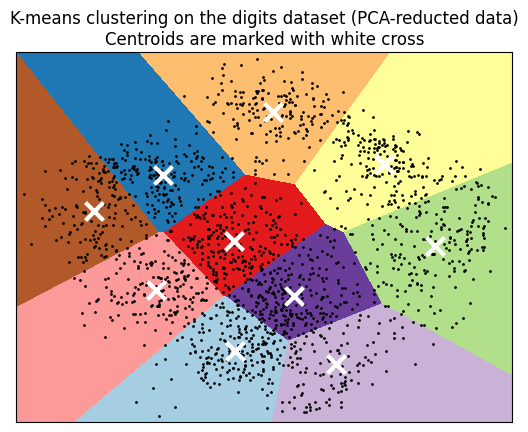

In [9]:
# Visualize the results on PCA-reduced data

import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

h = 0.02

x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation='nearest',
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect='auto',
    origin='lower'
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker='x',
    s=169,
    linewidths=3,
    color='w',
    zorder=10
)
plt.title(
    'K-means clustering on the digits dataset (PCA-reducted data)\n'+
    'Centroids are marked with white cross'
)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

# EX2) A demo of strctured Ward hierarchical clustering on an image of coins

In [12]:
# Generate data

from skimage.data import coins

orig_coins = coins()

In [14]:
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.transform import rescale

smoothened_coins = gaussian_filter(orig_coins, sigma=2)
rescaled_coins = rescale(
    smoothened_coins,
    0.2,
    mode='reflect',
    anti_aliasing=False
)

X = np.reshape(rescaled_coins, (-1, 1))

In [15]:
# Define structure of the data

from sklearn.feature_extraction.image import grid_to_graph

connectivity = grid_to_graph(*rescaled_coins.shape)

In [16]:
# Compute clustering

from time import time
from sklearn.cluster import AgglomerativeClustering

print('Compute structured hierarchical clustring...')
st = time()
n_clusters = 27
ward = AgglomerativeClustering(
    n_clusters=n_clusters, linkage='ward', connectivity=connectivity
)
ward.fit(X)
label = np.reshape(ward.labels_, rescaled_coins.shape)
print(f'Elapsed time: {time()-st:.3f}s')
print(f'Number of pixels: {label.size}')
print(f'Number of clusters: {np.unique(label).size}')

Compute structured hierarchical clustring...
Elapsed time: 0.117s
Number of pixels: 4697
Number of clusters: 27


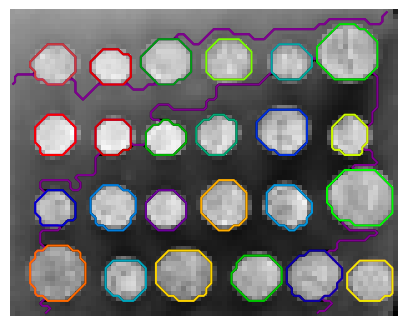

In [17]:
# Plot the results on an image

import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.imshow(rescaled_coins, cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(
        label == l, colors = [plt.cm.nipy_spectral(l/float(n_clusters))]
    )

plt.axis('off')
plt.show()

# EX3) A demo of mean-shift clustering algorithm

- [mean-shift](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html#sklearn.cluster.MeanShift)

In [19]:
import numpy as np

from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs

In [21]:
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, _ = make_blobs(n_samples=10_000, centers=centers, cluster_std=0.6)

In [23]:
# Compute clustering with MeanShift

bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print('number of estimated cluster : %d' % n_clusters_)

number of estimated cluster : 3


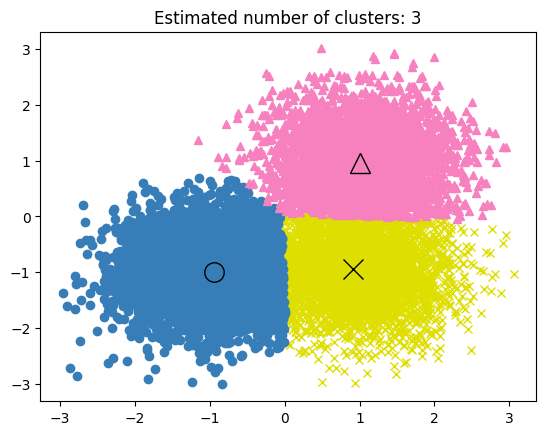

In [26]:
# Plot result

import matplotlib.pyplot as plt

plt.figure(1)
plt.clf()

colors = ['#dede00', '#377eb8', '#f781bf']
markers = ['x', 'o', '^']

for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], markers[k], color=col)
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        markers[k],
        markerfacecolor=col,
        markeredgecolor='k',
        markersize=14
    )

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# EX4) Adjustment for chance in clustering performance evaluation

- 클러스터링 평가하기

In [31]:
from sklearn import metrics

score_funcs = [
    ('V-measure', metrics.v_measure_score),
    ('Rand index', metrics.rand_score),
    ('ARI', metrics.adjusted_rand_score),
    ('MI', metrics.mutual_info_score),
    ('NMI', metrics.normalized_mutual_info_score),
    ('AMI', metrics.adjusted_mutual_info_score),
]


In [38]:
# 1) fixed ground truth labels and growing number of clusters

import numpy as np
rng = np.random.RandomState(0)

def random_labels(n_samples, n_classes):
    return rng.randint(low=0, high=n_classes, size=n_samples)

In [39]:
def fixed_classes_uniform_labelings_scores(
        score_func, n_samples, n_clusters_range, n_classes, n_runs=5
):
    scores = np.zeros((len(n_clusters_range), n_runs))
    labels_a = random_labels(n_samples=n_samples, n_classes=n_classes)

    for i, n_clusters in enumerate(n_clusters_range):
        for j in range(n_runs):
            labels_b = random_labels(n_samples=n_samples, n_classes=n_clusters)
            scores[i, j] = score_func(labels_a, labels_b)

    return scores

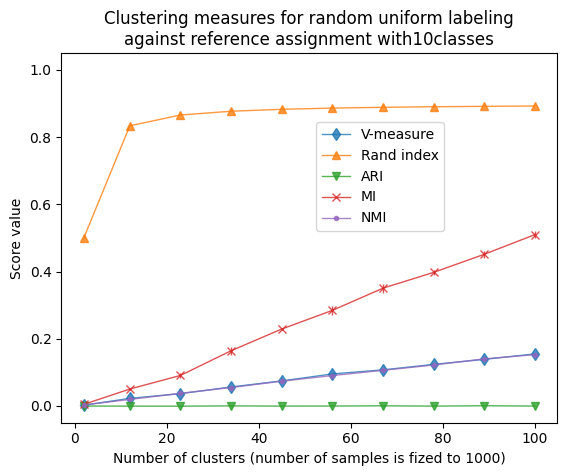

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

n_samples = 1000
n_classes = 10
n_clusters_range = np.linspace(2, 100, 10).astype(int)
plots, names = [], []

sns.color_palette('colorblind')
plt.figure(1)

for marker, (score_name, score_func) in zip("d^vx.", score_funcs):
    scores = fixed_classes_uniform_labelings_scores(
        score_func, n_samples, n_clusters_range, n_classes
    )
    plots.append(
        plt.errorbar(
            n_clusters_range,
            scores.mean(axis=1),
            scores.std(axis=1),
            alpha=0.8,
            linewidth=1,
            marker=marker
        )[0]
    )
    names.append(score_name)

plt.title(
    'Clustering measures for random uniform labeling\n'+
    'against reference assignment with'+str(n_classes)+'classes'
)

plt.xlabel('Number of clusters (number of samples is fized to %d)' % n_samples)
plt.ylabel('Score value')
plt.ylim(bottom=-0.05, top=1.05)
plt.legend(plots, names, bbox_to_anchor=(0.5, 0.5))
plt.show()

In [43]:
# 2) varying number of classes and clusters

def uniform_labelings_scores(score_func, n_samples, n_clusters_range, n_runs=5):
    scores = np.zeros((len(n_clusters_range), n_runs))

    for i, n_clusters in enumerate(n_clusters_range):
        for j in range(n_runs):
            labels_a = random_labels(n_samples=n_samples, n_classes=n_clusters)
            labels_b = random_labels(n_samples=n_samples, n_classes=n_clusters)
            scores[i, j] = score_func(labels_a, labels_b)

    return scores

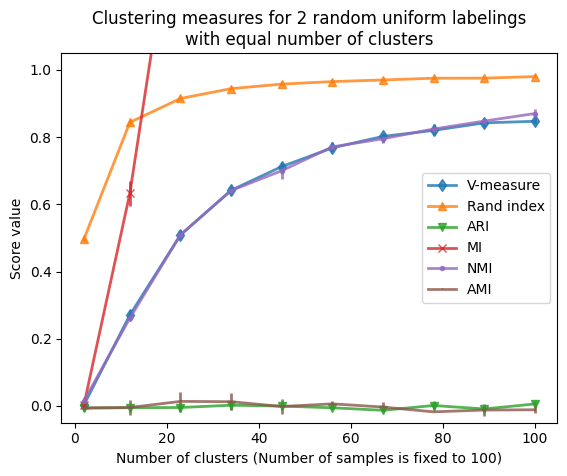

In [44]:
n_samples = 100
n_clusters_range = np.linspace(2, n_samples, 10).astype(int)

plt.figure(2)

plots = []
names = []

for marker, (score_name, score_func) in zip('d^vx.,', score_funcs):
    scores = uniform_labelings_scores(score_func, n_samples, n_clusters_range)
    plots.append(
        plt.errorbar(
            n_clusters_range,
            np.median(scores, axis=1),
            scores.std(axis=1),
            alpha=0.8,
            linewidth=2,
            marker=marker,
        )[0]
    )
    names.append(score_name)

plt.title(
    'Clustering measures for 2 random uniform labelings\nwith equal number of clusters'
)
plt.xlabel(f'Number of clusters (Number of samples is fixed to {n_samples})')
plt.ylabel('Score value')
plt.legend(plots, names)
plt.ylim(bottom=-0.05, top=1.05)
plt.show()